In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_parquet('../../data/sber_smm/smm-event.parquet')

In [3]:
df

,user_id,datetime,event,item_id,category_id,price
0,1199174,2023-02-13 03:12:19.131,2,1861088,5395,-0.042062
1,3124963,2023-02-13 09:38:55.674,2,2084441,1531,0.079817
2,2106055,2023-02-13 08:26:05.004,2,2586689,9294,-0.038990
3,4169844,2023-02-13 16:55:08.470,2,2586689,9294,-0.038990
4,7472260,2023-02-13 03:30:13.093,2,2586689,9294,-0.038990
...,...,...,...,...,...,...
196644015,6406462,2023-04-02 16:45:42.712,2,2687047,6206,-0.041476
196644016,6406462,2023-04-02 16:45:42.323,2,2687047,6206,-0.041476
196644017,8726613,2023-04-02 09:41:37.348,2,1244056,9295,-0.030982
196644018,8726613,2023-04-02 09:41:39.692,2,1244056,9295,-0.030982


<Axes: >

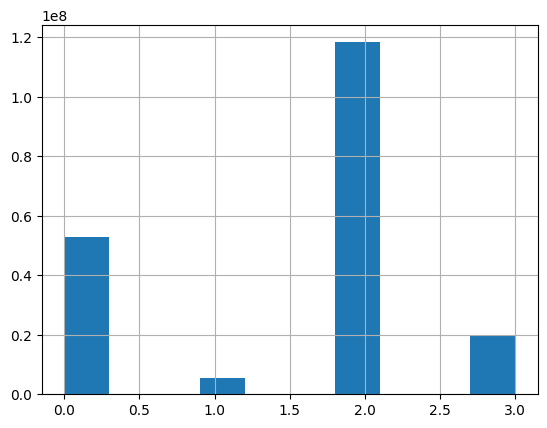

In [4]:
df.event.hist()

In [5]:
# drop favorite and cart. Since cart < purchase
df = df[(df['event'] != 1) & (df['event'] != 3)]

In [6]:
df.drop(['category_id', 'price'], axis=1, inplace=True)

/home/jovyan/miniconda3/envs/recsys/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
df.event.replace([0, 2], [1, 0], inplace=True)

/home/jovyan/miniconda3/envs/recsys/lib/python3.9/site-packages/pandas/core/series.py:4576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [8]:
df = df[["user_id", "item_id", "datetime", "event"]]

In [9]:
print(
    f"Number of the unique event - {df['event'].nunique()}.\n"
)

Number of the unique event - 2.



In [10]:
max_session_type = df.groupby(['user_id', 'item_id'])['event'].max().rename('max_type')

In [11]:
df = df.join(max_session_type, ['user_id', 'item_id'])

In [12]:
df.shape

(171304101, 5)

In [13]:
df = df[df['event'] == df['max_type']]

In [14]:
df.shape

(148419772, 5)

In [15]:
df.reset_index(drop=True, inplace=True)
df.drop(columns='max_type', inplace=True)

In [17]:
click_weight, purchase_weight = \
    df.shape[0] / df['event'].value_counts()

In [19]:
df.shape[0] / df['event'].value_counts()

0    1.554808
1    2.802427
Name: event, dtype: float64

In [20]:
df = df.join(
    df.groupby(['user_id', 'item_id'])['event'].count().rename('count'),
    on=['user_id', 'item_id']
)

In [21]:
df.drop_duplicates(['user_id', 'item_id'], inplace=True)

In [22]:
click_border = click_weight * (purchase_weight // click_weight)

In [23]:
df['weight'] = np.where(
    df['event'] == 0,
    np.minimum(click_border, df['count'] * click_weight),
    df['count'] * purchase_weight
)

In [24]:
df.drop(columns=['event', 'count'], inplace=True)

In [27]:
df.datetime = pd.to_datetime(df.datetime).astype(int)

In [25]:
df.to_parquet('../../data/sber_smm/interactions.parquet')